In [333]:
import pandas as pd
import ast
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from afinn import Afinn

!pip freeze > requirements.txt

 # Исследование данных

In [334]:
hotels = pd.read_csv('hotels.csv')
df_test = pd.read_csv('hotels_test.csv')
sample_submission = pd.read_csv('submission.csv')
hotels.head(3)
hotels


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.2,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066


In [335]:
hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [336]:
#так как строк с пропущенными данными очень малое количество относительно общей выборки, то их можно удалить
hotels = hotels.dropna(how='any', axis=0)


Очистка от дубликатов

In [337]:
# Проверим на дубли и избавимся от них, если они есть
all_columns = list(hotels.columns) 
hotels_duplicates = hotels[hotels.duplicated(subset=all_columns)]
print(f'Number of duplicates: {hotels_duplicates.shape[0]}')
hotels.drop_duplicates(inplace=True, ignore_index=True) 

Number of duplicates: 307


C:\Users\user\AppData\Local\Temp\ipykernel_6064\2667173139.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels.drop_duplicates(inplace=True, ignore_index=True)


# Исследование и проектирование признаков:

Начнем с названия отеля:

In [338]:
hotels['hotel_name'].describe()

count                                         384048
unique                                          1475
top       Britannia International Hotel Canary Wharf
freq                                            3587
Name: hotel_name, dtype: object

Уникальных значений названия отелей 1466. Слишком много чтобы кодировать, пока не будем с ними ничего делать.

In [339]:
# посмотрим на общее количество действительных отзывов об отеле
hotels['total_number_of_reviews'].describe()

count    384048.000000
mean       2748.444994
std        2322.161007
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3633.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

Посмотрим на средний балл отеля, рассчитанный на основе последнего комментария за последний год:

In [340]:
hotels['average_score'].describe()

count    384048.000000
mean          8.397838
std           0.548953
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

тут никаих подозрений на выбросы нет, идем дальше

Посмотрим на общее количество слов в отрицательном отзыве

In [341]:

hotels['review_total_negative_word_counts'].describe()

count    384048.000000
mean         18.546166
std          29.721376
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

Картина похожа на предыдущий признак, кто-то был многословен, но, судя по среднему и другим показателям, таких немного, все выглядит нормально. Далее:

Количество отзывов, которые рецензенты дали в прошлом:

In [342]:
hotels['total_number_of_reviews_reviewer_has_given'].describe()

count    384048.000000
mean          7.162068
std          11.039141
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

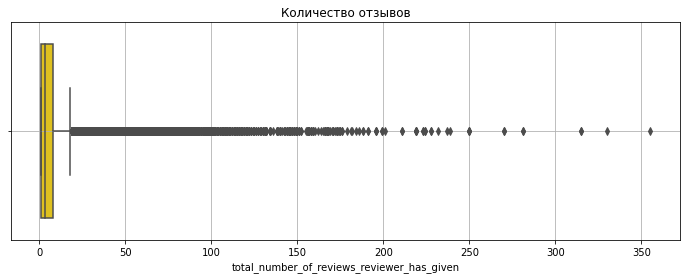

In [343]:
fig, ax = plt.subplots(figsize=(12, 4)) 
# строим boxplot 
sns.boxplot(data=hotels, x='total_number_of_reviews_reviewer_has_given', palette='prism', ax=ax) 
#задаём названия графикам
ax.set_title('Количество отзывов')
plt.grid()

Чаще всего люди имею не более 10 отзывов

Общее количество действительных отзывов об отеле:

In [344]:
hotels['total_number_of_reviews'].describe()

count    384048.000000
mean       2748.444994
std        2322.161007
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3633.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

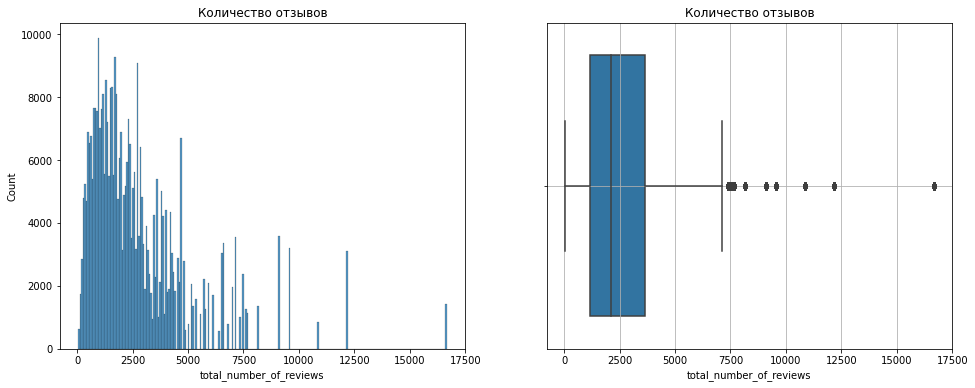

In [345]:
# для полноты картины визуализируем признак:
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 
#строим гистограмму
sns.histplot(data=hotels, x='total_number_of_reviews', ax=axes[0])
# строим boxplot 
sns.boxplot(data=hotels, x='total_number_of_reviews', ax=axes[1]) 
#задаём названия графикам
axes[0].set_title('Количество отзывов')
axes[1].set_title('Количество отзывов')
plt.grid()

Тут, вроде, ничего интересного

Далее, число оценок без отзывов и без проверки:

In [346]:
# для числа оценок без проверки:
hotels['additional_number_of_scoring'].describe()

count    384048.000000
mean        500.540440
std         501.244548
min           1.000000
25%         169.000000
50%         345.000000
75%         666.000000
max        2682.000000
Name: additional_number_of_scoring, dtype: float64

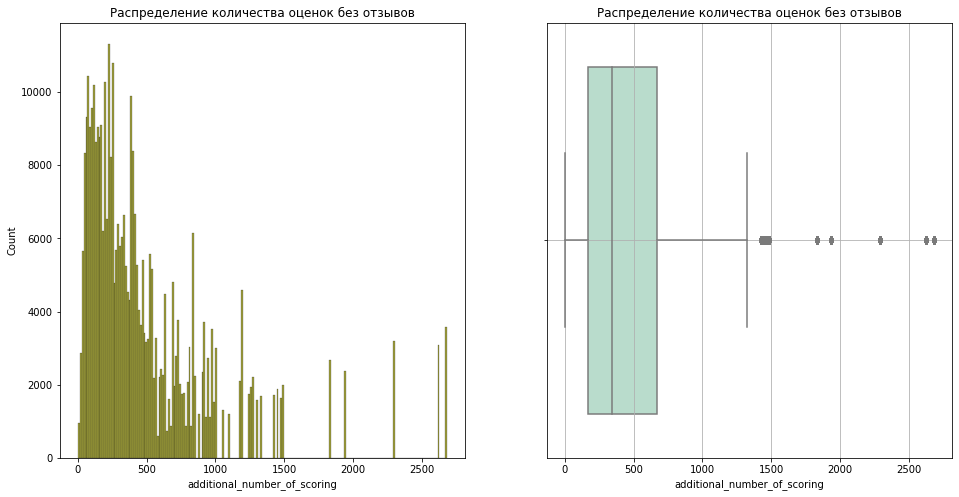

In [347]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 
#строим гистограмму
sns.histplot(data=hotels, x='additional_number_of_scoring',color='olive', ax=axes[0])
# строим boxplot 
sns.boxplot(data=hotels, x='additional_number_of_scoring', palette='Pastel2', ax=axes[1]) 
#задаём названия графикам
axes[0].set_title('Распределение количества оценок без отзывов')
axes[1].set_title('Распределение количества оценок без отзывов')
plt.grid()

In [348]:
# количество, превышающее 1350, выглядит подозрительным. 
# посмотрим, сколько таких строк:
display(hotels[hotels['additional_number_of_scoring']>=1350].shape[0])

22160

In [349]:
# Удалим эти строки:
hotels = hotels[hotels['additional_number_of_scoring'] < 1350]


In [350]:
# Для дальнейшей работы объединим трейн и тест датасеты
# в тесте у нас нет значения reviewer_score, мы его должны предсказать, заполняем нулями
df_test['reviewer_score'] = 0 
hotels['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
# обьединяем
hotels = pd.concat([hotels, df_test], ignore_index = True)
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


# Создание и преобразование признаков


Начнем с тэгов. Преобразуем их в читаемой формат:

In [351]:

#количество уникальных тегов
hotels['tags'] = hotels['tags'].apply(lambda x: ast.literal_eval(x))
combined_tags = [element for sublist in hotels['tags'] for element in sublist]
len(set(combined_tags))
counter = Counter(combined_tags)
counter
counter = pd.DataFrame.from_dict(counter, orient='index', columns = ['count'])
counter = counter.sort_values(by = 'count', ascending=False)
counter.head(20)


,count
Leisure trip,397777
Submitted from a mobile device,291895
Couple,240113
Stayed 1 night,181351
Stayed 2 nights,127576
Solo traveler,103307
Stayed 3 nights,92550
Business trip,78837
Group,62265
Family with young children,57936


In [352]:
# оставим 15 самых популярных тэгов и создадим из них список
top_tags = counter.nlargest(20, columns = 'count')
top_tags_list = list(top_tags.index)

In [353]:
# создадим 15 новых столбцов с тэгами горячим кодированием: 
for tag in top_tags_list:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

Преобразуем признак с адресом отеля:

In [354]:
#рассмотрим поподробнее признак hotel_address. Судя по виду строки у этого признака последним словом является название страны, рассмотрим так ли это
countries = [i.split()[-1] for i in hotels['hotel_address']]
countries = set(countries)
display(countries)


{'Austria', 'France', 'Italy', 'Kingdom', 'Netherlands', 'Spain'}

In [355]:
#получается, что у нас всего 6 стран с адресами. Убедимся, что перед Kingdom везде стоит United, а не какое нибудь еще королевство
countries_united_only = [i.split()[-2] for i in hotels['hotel_address'] if (i.split()[-1] == 'Kingdom')]
print(len(countries_united_only))
countries_kingdom_only = [i.split()[-1] for i in hotels['hotel_address'] if (i.split()[-1] == 'Kingdom')]
print(len(countries_kingdom_only))
#да, перед Kingdom везде стоит United, других королевств не обнаружено

240140
240140


In [356]:
#теперь глянем на города. Судя по выборке город записан перед названием страны. Но у United Kingdom есть еще пара значений перед названием города, учтем это. Переделаем список сразу в множество,
#для получения уникальных значений.
cities = set([i.split()[-5] if (i.split()[-1] == 'Kingdom') else i.split()[-2]  for i in hotels['hotel_address'] ])
print(cities)


{'Amsterdam', 'London', 'Vienna', 'Milan', 'Barcelona', 'Paris'}


Судя по полученным данным у нас отели из 6 стран и на каждую страну по 1 городу. Так что из всего признака hotel_address можно оставить только название города.

In [357]:
hotels['hotel_address'] = hotels['hotel_address'].apply(lambda i:i.split()[-5] if (i.split()[-1] == 'Kingdom') else i.split()[-2])
hotels['hotel_city'] = hotels['hotel_address']


In [358]:
#закодируем его
hotels = pd.get_dummies(hotels,columns=['hotel_address'],prefix='address')


У нас есть столбец с датой отзыва. Переведем его в формат дат, а потом выделим месяц и год отзыва, а также день недели. И, так как возможна сезонность, создадим еще признак времени года. Для создания признака по времени года так же выделим показатель порядкового дня года и закодируем его.  

In [359]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
# создадим столбец с годом:
hotels['month'] = hotels['review_date'].dt.year
# создадим столбец с месяцем отзыва:
hotels['year'] = hotels['review_date'].dt.month
# создадим столбец с днем недели:
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek
# создадим столбец с порядковым днем года:
hotels['season'] = hotels['review_date'].dt.dayofyear
# удалим столбец с датой, тк из него извлекли все, что запланировали
hotels = hotels.drop('review_date', axis =1)
display(hotels.head())


,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,address_Amsterdam,address_Barcelona,address_London,address_Milan,address_Paris,address_Vienna,month,year,day_of_week,season
0,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,0,0,1,0,0,0,2016,2,4,50
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,0,0,1,0,0,0,2017,1,3,12
2,32,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,...,0,0,0,0,1,0,2016,10,1,292
3,34,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,...,0,0,0,0,1,0,2015,9,1,265
4,914,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,...,1,0,0,0,0,0,2016,3,5,65


In [360]:
# исследуем новый столбец Season:
hotels['season'].describe()


count    490823.000000
mean        182.066417
std         102.244469
min           1.000000
25%          96.000000
50%         185.000000
75%         267.000000
max         366.000000
Name: season, dtype: float64

Все выглядит предсказуемо. Закодируем его порядковым кодированием через лямбда функцию так:

Зима: дни с 1 по 60 день плюс 335 по 366, будет закодирована как 1

Весна: с 61 по 153, закодируем как 2

Лето: с 154 по 246, закодируем как 3

Осень: с 247 по 334, закодируем как 4.

In [361]:
hotels['season']= hotels['season'].apply(lambda x: 1 if (1<=x<61 or 335<=x<=366) \
    else 2 if 61<=x<=153 \
    else 3 if 154<=x<=246 \
    else 4 )
hotels['season'].value_counts()


3    138480
2    125483
1    114776
4    112084
Name: season, dtype: int64

Проанализируем сами отзывы c с помощью Afinn. Afinn — это подход к анализу настроений на основе списка слов. Он не нормализует оценки и мы получаем коэффициент, соотносимый с масштабом количества слов отзыва. То есть, своего рода взвешенную по количеству слов оценку:

In [362]:
# формируем единый блок текста обеих частей отзыва и избавляемся от меток отсутствия слов:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', ''))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', ''))
hotels['review'] = hotels['positive_review_temp'] + ' ' + hotels['negative_review_temp']


In [363]:
%%time
# получаем счет:
afinn = Afinn()
hotels['afinn_score'] = hotels['review'].apply(lambda x: afinn.score(x))

CPU times: total: 5min 51s
Wall time: 5min 56s


In [364]:
# ограничим размеры диапазона значений по методу Тьюки:
def get_outliers_bonds(data, feature):
    """Определяем границы диапазонов для ограничения значений"""
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower = quartile_1 - (iqr * 1.5)
    upper = quartile_3 + (iqr * 1.5)
    return lower, upper


lower_bound, upper_bound = get_outliers_bonds(hotels, 'afinn_score')

hotels['afinn_score'] = hotels['afinn_score'].apply(
    lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Нормализация и стандартизация

Рассмотрим распределения исходных числовых признаков на графике методом визуализации kdeplot(): 

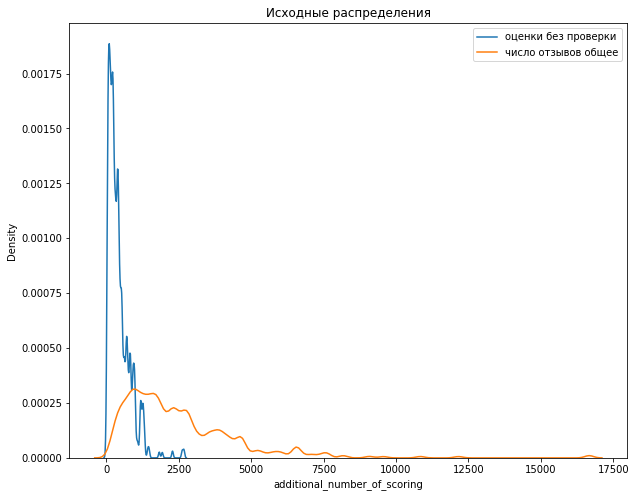

In [365]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(hotels['additional_number_of_scoring'], ax=ax1, label ='оценки без проверки')
sns.kdeplot(hotels['total_number_of_reviews'], ax=ax1, label ='число отзывов общее')
plt.legend()

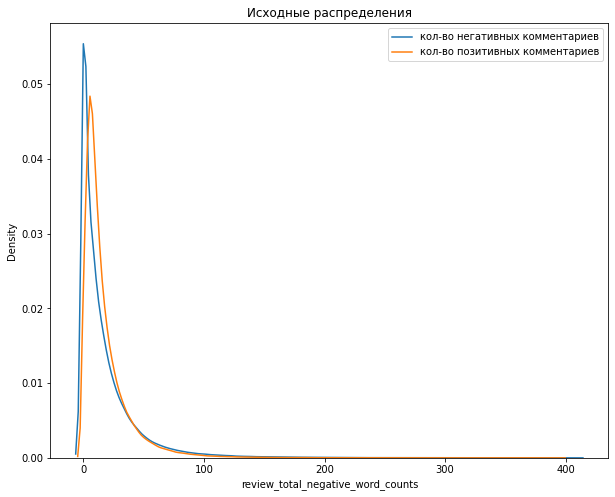

In [366]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(hotels['review_total_negative_word_counts'], ax=ax1, label ='кол-во негативных комментариев')
sns.kdeplot(hotels['review_total_positive_word_counts'], ax=ax1, label ='кол-во позитивных комментариев')
plt.legend()

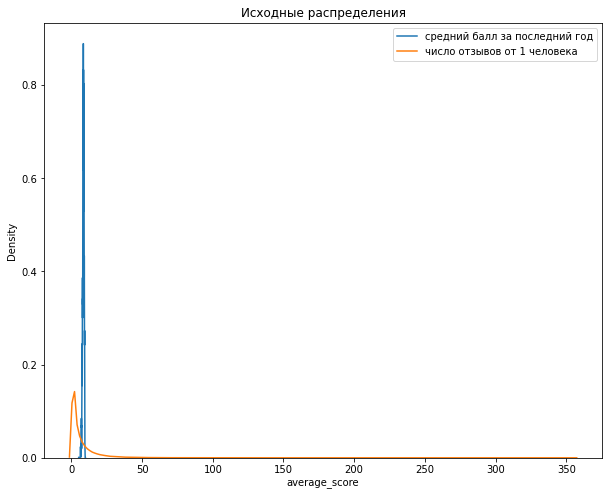

In [367]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(hotels['average_score'], ax=ax1, label ='средний балл за последний год')
sns.kdeplot(hotels['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='число отзывов от 1 человека')
plt.legend()

Соберем эти признаки в один список и нормализуем методом RobustScaler, тк он не учитывает выбросы, которые могут оставаться.

In [368]:
norm_cols = ['additional_number_of_scoring', 'average_score','review_total_negative_word_counts',
'review_total_positive_word_counts','total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given'
]
from sklearn import preprocessing
r_scaler = preprocessing.RobustScaler()
hotels[norm_cols] = r_scaler.fit_transform(hotels[norm_cols])
# посмотрим на них
hotels[norm_cols].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews,total_number_of_reviews_reviewer_has_given
count,490823.000000,490823.000000,490823.000000,490823.000000,490823.000000,490823.000000
mean,0.245244,0.014057,0.410429,0.384996,0.226022,0.605269
std,0.880005,0.773904,1.287914,1.219404,0.908972,1.587920
min,-0.762911,-4.571429,-0.391304,-0.611111,-0.883888,-0.285714
25%,-0.382629,-0.428571,-0.391304,-0.333333,-0.399190,-0.285714
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.617371,0.571429,0.608696,0.666667,0.600810,0.714286
max,5.530516,2.000000,17.347826,21.333333,6.599010,50.285714


# Корреляция

<AxesSubplot: >

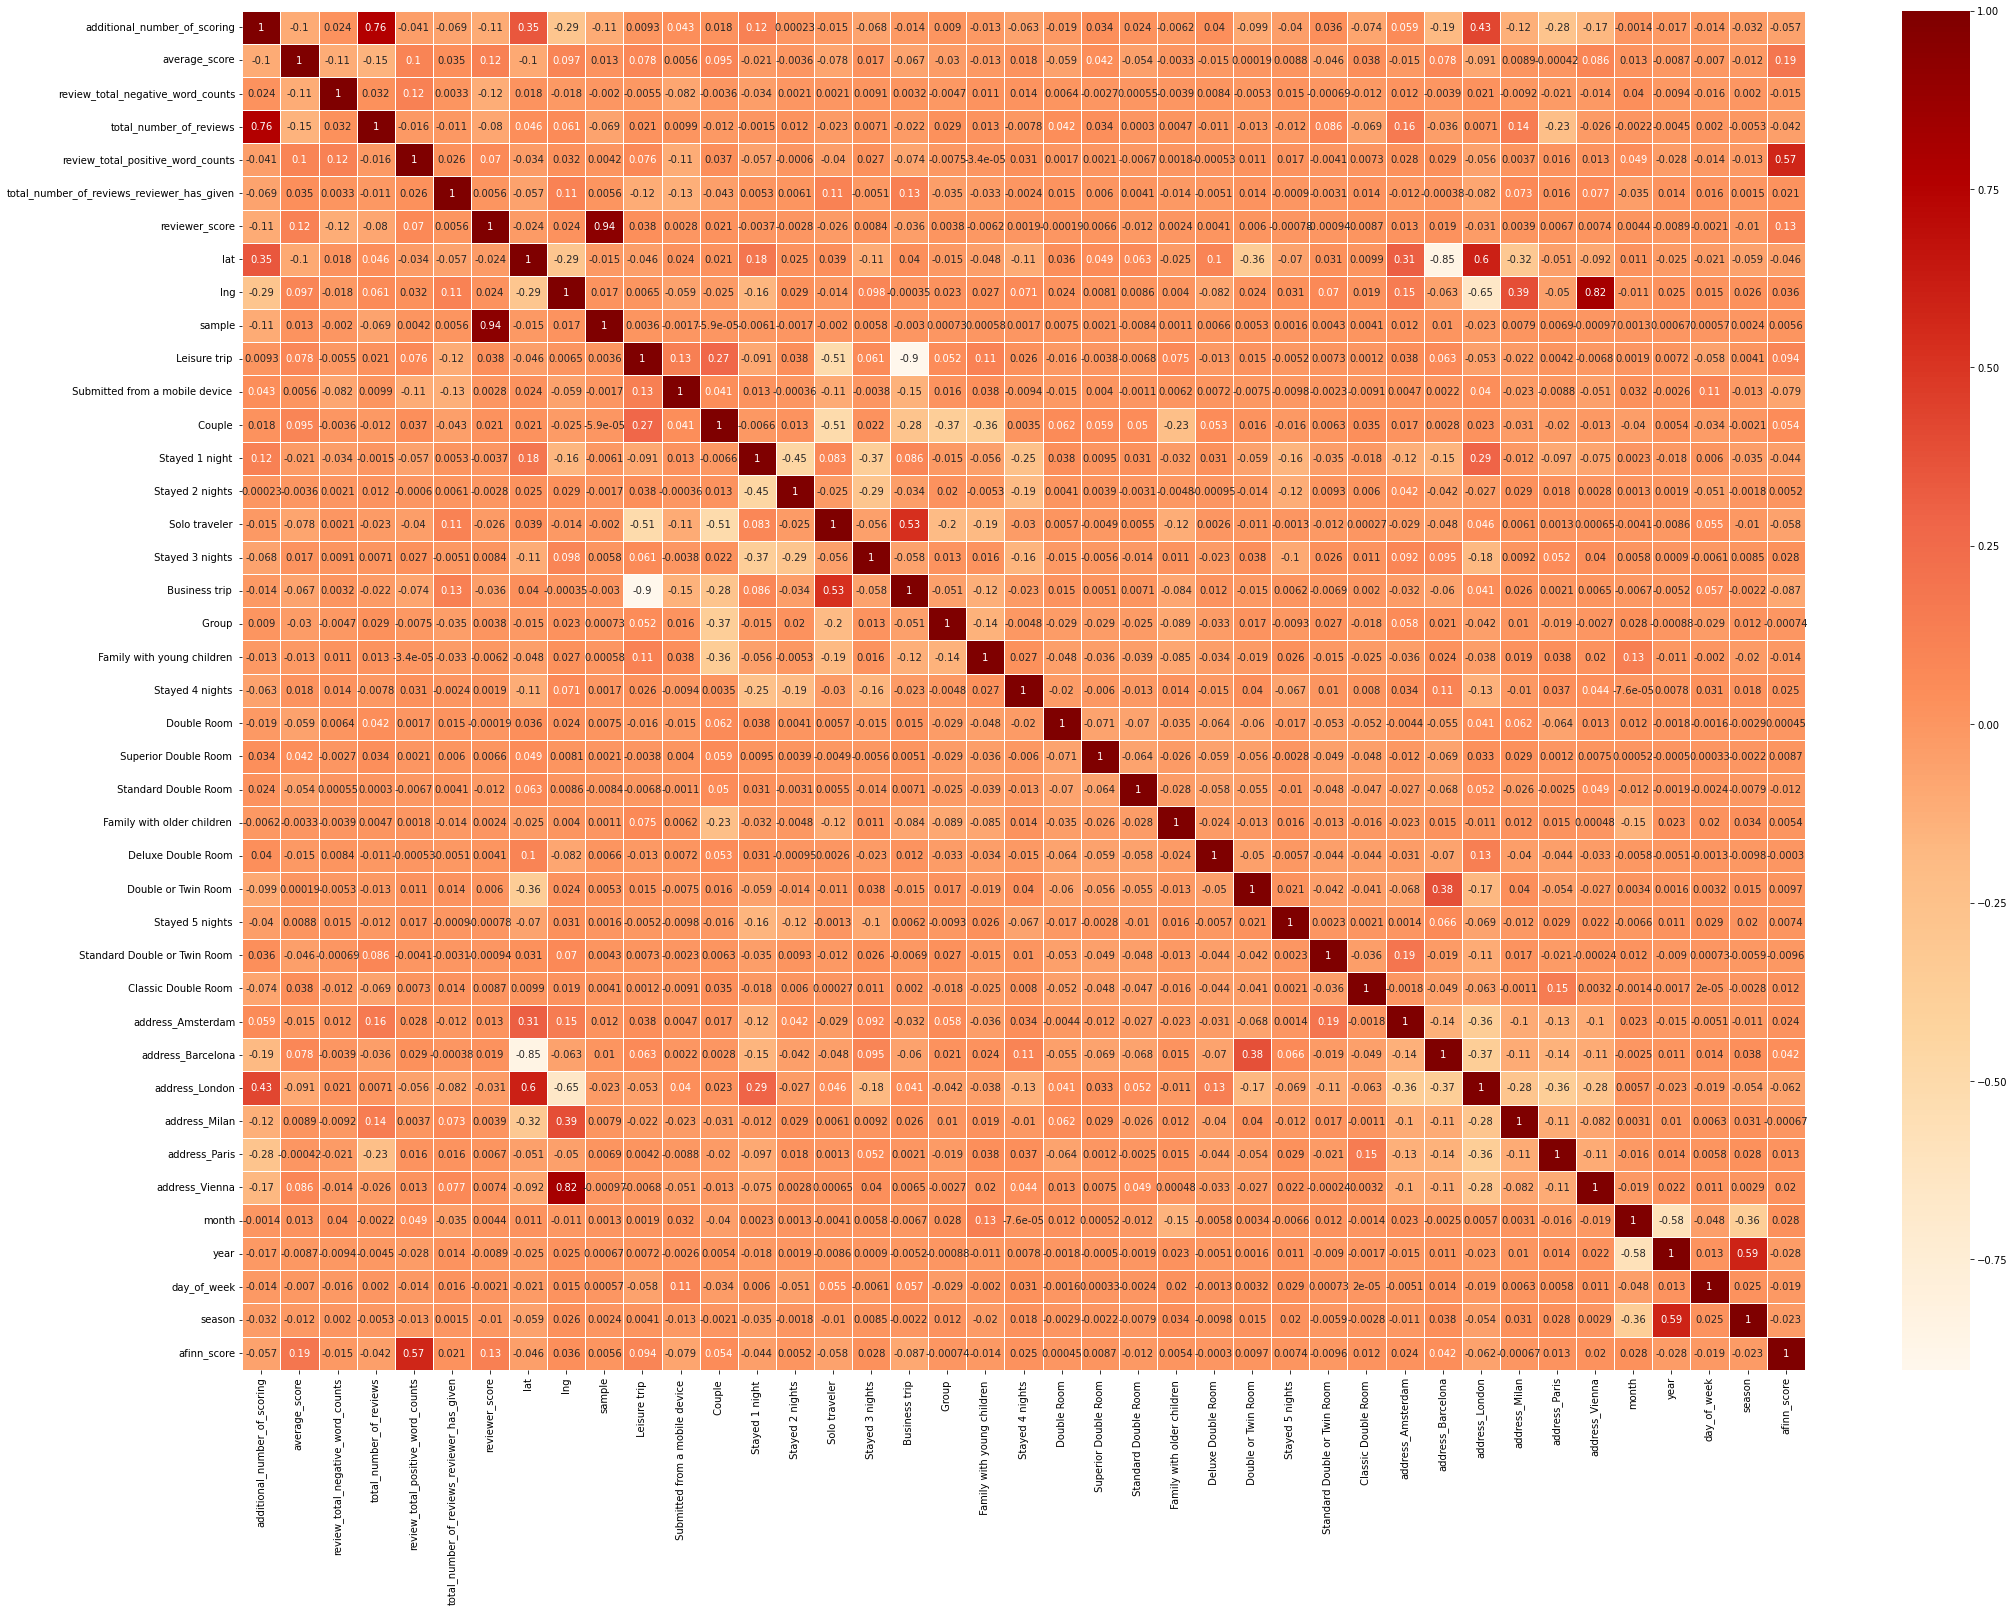

In [369]:
fig, ax = plt.subplots(figsize=(35,25))
sns.heatmap(hotels.corr(), annot=True, linewidths=.8, ax=ax, cmap = 'OrRd' )

In [370]:
# Видим, что есть некоторое количество признаков, которые обладают сильной прямой или обратной корреляцией.
# Удалим в каждой такой паре по одному:
hotels = hotels.drop(columns = [ 'total_number_of_reviews', ' Leisure trip ','lat','lng'], axis = 1)

<AxesSubplot: >

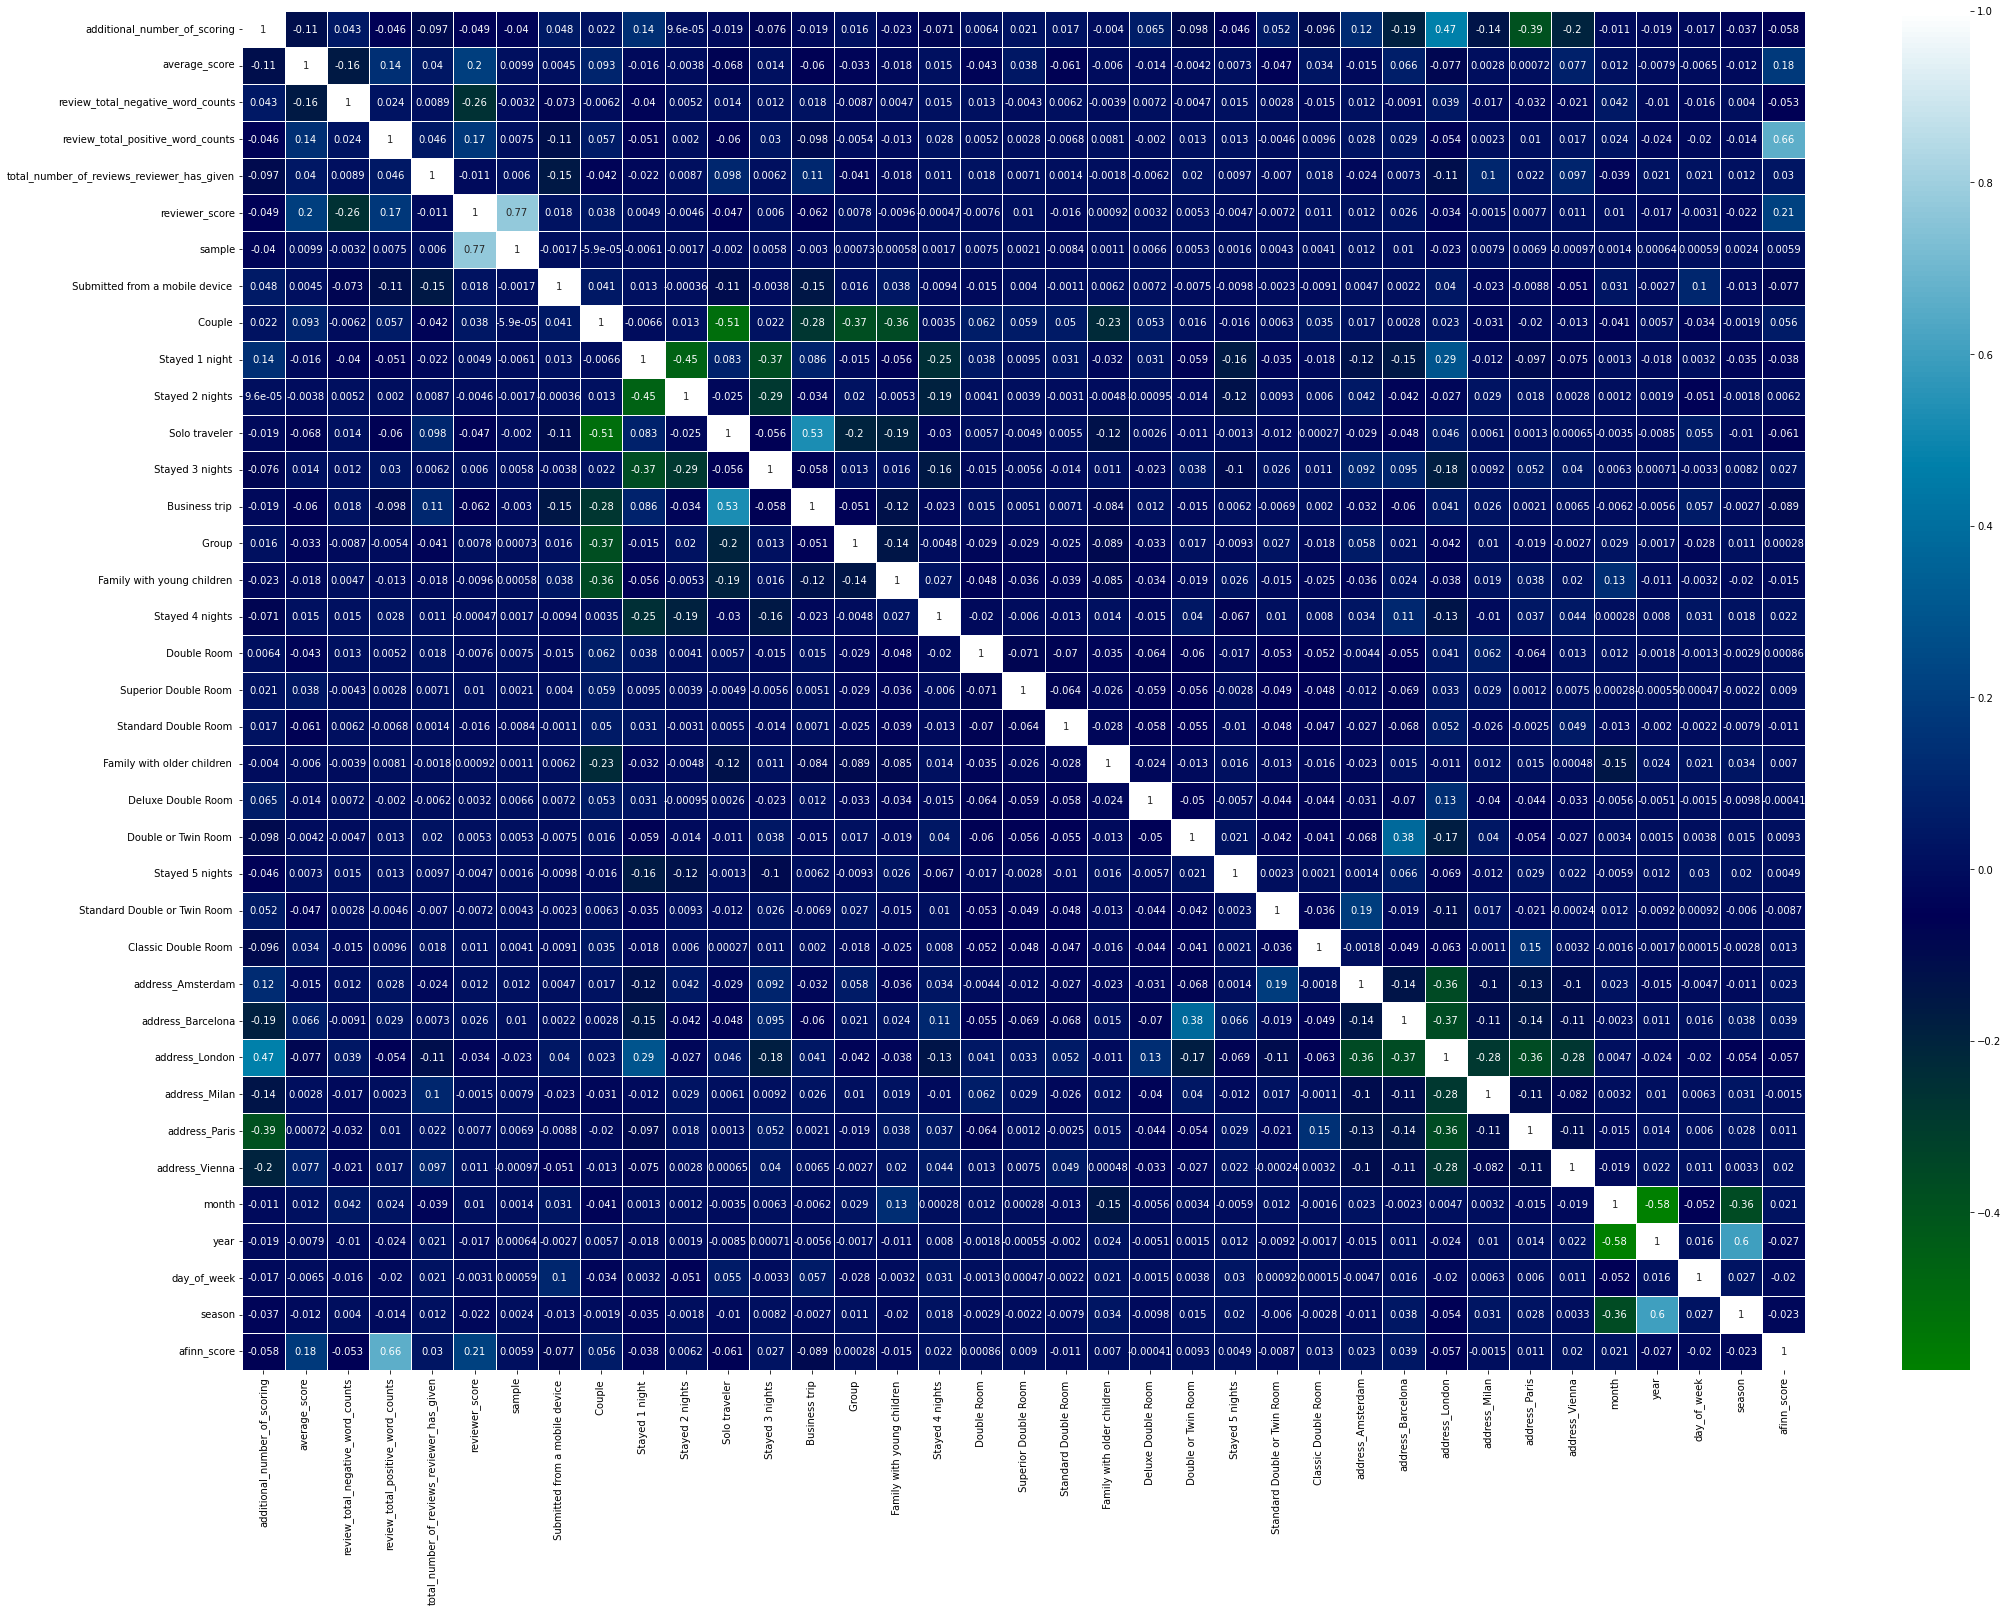

In [371]:
#еще раз глянем на тепловую карту корреляции после очистки, используя метод Спирмена теперь
fig, ax = plt.subplots(figsize=(35,25))
sns.heatmap(hotels.corr(method = 'spearman'), annot=True, linewidths=.8, ax=ax, cmap = 'ocean')

# Оценка значимости признаков для целевой переменной и обучение модели

In [372]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [373]:
# непрерывные признаки
num_cols = ['review_total_negative_word_counts', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given','afinn_score']


<AxesSubplot: >

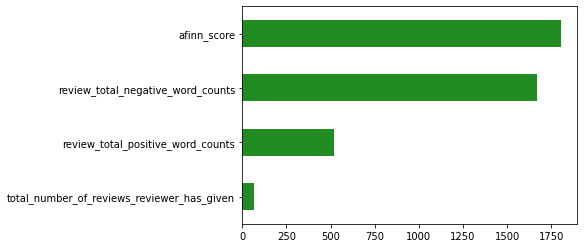

In [374]:
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из
# библиотеки sklearn. В основе метода оценки значимости переменных лежит анализ ANOVA.
from sklearn.feature_selection import f_classif # проведем тест anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color = 'forestgreen')

In [375]:
# удалим малозначимые признаки
hotels.drop(['total_number_of_reviews_reviewer_has_given'], axis=1, inplace=True)




<AxesSubplot: >

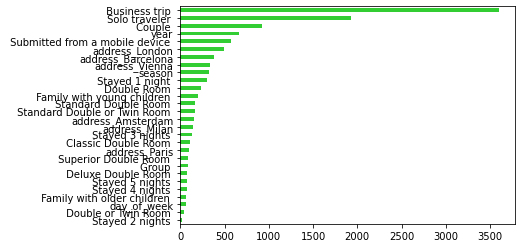

In [376]:
cat_cols = ['year', 'day_of_week', 'season', 'address_London', ' Submitted from a mobile device ', ' Couple ', ' Stayed 1 night ', ' Stayed 2 nights ',' Solo traveler ', ' Stayed 3 nights ', ' Business trip ', ' Group ', ' Family with young children ', ' Double or Twin Room ',' Standard Double or Twin Room ',
       ' Stayed 4 nights ',' Double Room ', ' Superior Double Room ',' Standard Double Room ',' Deluxe Double Room ',' Stayed 5 nights ',' Classic Double Room ',
       ' Family with older children ','address_Amsterdam', 'address_Barcelona', 'address_Milan', 'address_Paris',
       'address_Vienna']
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', color = 'limegreen')

In [377]:
# удалим малозначимые признаки
hotels.drop(['day_of_week',' Stayed 2 nights ',' Family with older children '
          , ' Double or Twin Room ','address_Milan',' Stayed 5 nights ', ' Stayed 4 nights ',' Deluxe Double Room ',' Group '], axis=1, inplace=True)


In [378]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)


In [379]:
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [380]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split 

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [381]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 26), (361888, 26), (361888, 25), (271416, 25), (90472, 25))

In [382]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
  
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


In [383]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12870693922096102


In [384]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [385]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


In [386]:
predict_submission

array([8.86 , 7.936, 8.279, ..., 7.806, 9.415, 7.021])

In [388]:
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.860,488440
1,7.936,274649
2,8.279,374688
3,9.622,404352
4,9.627,451596
5,8.727,302161
6,7.869,317079
7,8.130,13963
8,8.546,159785
9,8.061,195089
